# QUBO Max-Cut and Traveler Saleman Problem

Let's import some useful packages first

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer


## Max-Cut problem

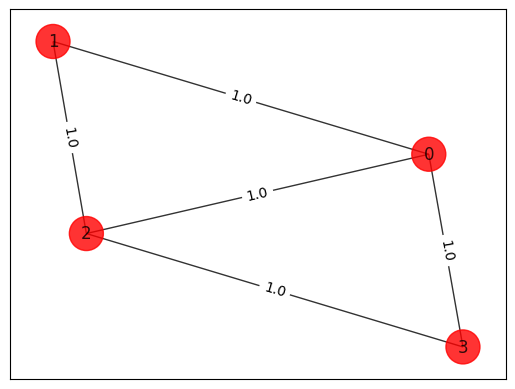

In [2]:
# Generate a graph of 4 nodes 

n = 4
G = nx.Graph()
G.add_nodes_from(np.arange(0,n,1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
# tuple is (i, j, weight) where (i, j) is the edge
G.add_weighted_edges_from(elist)


# Plot G graph
colors = ["r" for node in G.nodes()]
pos = nx.spring_layout(G)

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon = True)
    nx.draw_networkx(G, node_color = colors, node_size = 600, alpha = 0.8, ax = default_axes, pos = pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(G, colors, pos)

In [3]:
# Compute the weight matrix from the random graph
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        if temp != 0:
            w[i,j] = temp["weight"]

print(w)

[[0. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 1.]
 [1. 0. 1. 0.]]


## Mapping into the Ising problem

In [4]:
max_cut = Maxcut(w)
qp = max_cut.to_quadratic_program()
print(qp.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_3 - 2*x_1*x_2 - 2*x_2*x_3 + 3*x_0 + 2*x_1
  + 3*x_2 + 2*x_3

Subject to
  No constraints

  Binary variables (4)
    x_0 x_1 x_2 x_3



In [5]:
qubitOp, offset = qp.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian")
print(str(qubitOp))

Offset: -2.5
Ising Hamiltonian
SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ', 'IZZI', 'ZZII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j])


In [6]:
# Solving Quadratic Program using exact calssical eigensolver 
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(qp)
print(result.prettyprint())

objective function value: 4.0
variable values: x_0=1.0, x_1=0.0, x_2=1.0, x_3=0.0
status: SUCCESS


### Running it on quantum computer

In [7]:
algorithm_globals.random_seed = 123
seed = 12345

/var/folders/kz/_mr3r3b55qd2r5hd025yvpfw0000gn/T/ipykernel_20742/3196901592.py:4: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimzer)


energy: -1.4996861455587298
time: 2.816987991333008
max-cut objective: -3.99968614555873
solution: [0 1 0 1]
solution: objective 4.0


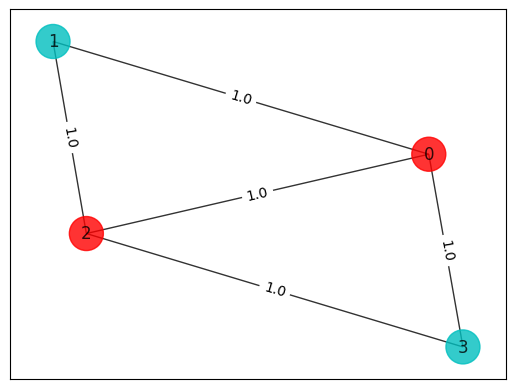

In [8]:
# Construct SamplingVQE
optimzer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimzer)

# Run SamplingVQE
result = vqe.compute_minimum_eigenvalue(qubitOp)

# Print results
x = max_cut.sample_most_likely(result.eigenstate)
print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
print("max-cut objective:", result.eigenvalue.real + offset)
print("solution:", x)
print("solution: objective", qp.objective.evaluate(x))

# plot results 
colors = ["r" if x[i]==0 else "c" for i in range(n)]
draw_graph(G, colors, pos)

We can plot out the ansatz by running the following code 

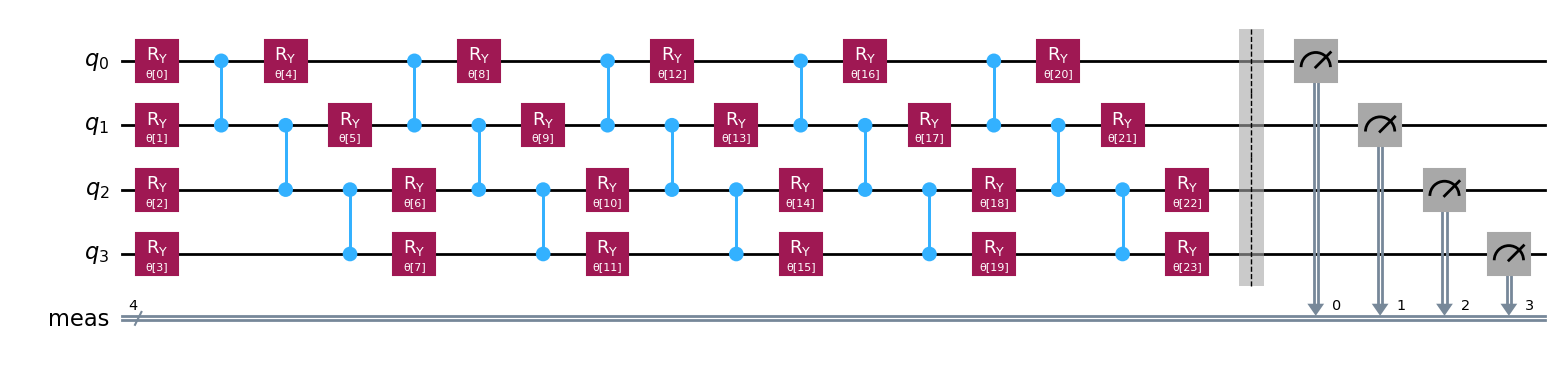

In [9]:
ry.decompose().draw("mpl")

## Traveling Salesman Problem

distance
 [[ 0. 13. 71.]
 [13.  0. 62.]
 [71. 62.  0.]]


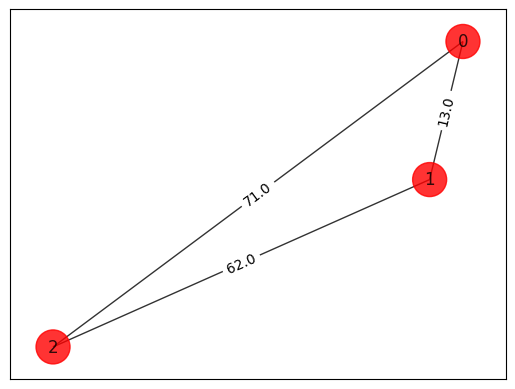

In [10]:
# Generating a graph of 4 nodes
n = 3
num_qubits = n**2
tsp = Tsp.create_random_instance(n, seed=1234)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in tsp.graph.nodes]
pos = [tsp.graph.nodes[node]["pos"] for node in tsp.graph.nodes]
draw_graph(tsp.graph, colors, pos)

## Mapping to the Ising problem

In [11]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  13*x_0_0*x_1_1 + 13*x_0_0*x_1_2 + 71*x_0_0*x_2_1 + 71*x_0_0*x_2_2
  + 13*x_0_1*x_1_0 + 13*x_0_1*x_1_2 + 71*x_0_1*x_2_0 + 71*x_0_1*x_2_2
  + 13*x_0_2*x_1_0 + 13*x_0_2*x_1_1 + 71*x_0_2*x_2_0 + 71*x_0_2*x_2_1
  + 62*x_1_0*x_2_1 + 62*x_1_0*x_2_2 + 62*x_1_1*x_2_0 + 62*x_1_1*x_2_2
  + 62*x_1_2*x_2_0 + 62*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



In [12]:
from qiskit_optimization.converters import QuadraticProgramToQubo

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 5481.0
Ising Hamiltonian:
SparsePauliOp(['IIIIIIIIZ', 'IIIIIIIZI', 'IIIIIIZII', 'IIIIIZIII', 'IIIIZIIII', 'IIIZIIIII', 'IIZIIIIII', 'IZIIIIIII', 'ZIIIIIIII', 'IIIIIIIZZ', 'IIIIIIZIZ', 'IIIIIZIIZ', 'IIIIZIIIZ', 'IIIZIIIIZ', 'IIZIIIIIZ', 'IZIIIIIIZ', 'ZIIIIIIIZ', 'IIIIIIZZI', 'IIIIIZIZI', 'IIIIZIIZI', 'IIIZIIIZI', 'IIZIIIIZI', 'IZIIIIIZI', 'ZIIIIIIZI', 'IIIIIZZII', 'IIIIZIZII', 'IIIZIIZII', 'IIZIIIZII', 'IZIIIIZII', 'ZIIIIIZII', 'IIIIZZIII', 'IIIZIZIII', 'IIZIIZIII', 'IZIIIZIII', 'ZIIIIZIII', 'IIIZZIIII', 'IIZIZIIII', 'IZIIZIIII', 'ZIIIZIIII', 'IIZZIIIII', 'IZIZIIIII', 'ZIIZIIIII', 'IZZIIIIII', 'ZIZIIIIII', 'ZZIIIIIII'],
              coeffs=[-919.  +0.j, -919.  +0.j, -919.  +0.j, -914.5 +0.j, -914.5 +0.j,
 -914.5 +0.j, -943.5 +0.j, -943.5 +0.j, -943.5 +0.j,  438.5 +0.j,
  438.5 +0.j,  438.5 +0.j,    3.25+0.j,    3.25+0.j,  438.5 +0.j,
   17.75+0.j,   17.75+0.j,  438.5 +0.j,    3.25+0.j,  438.5 +0.j,
    3.25+0.j,   17.75+0.j,  438.5 +0.j,   17.75+0.j,    3.25+0.j,
    3.25+0.j, 

In [13]:
result = exact.solve(qubo)
print(result.prettyprint())

objective function value: 146.0
variable values: x_0_0=0.0, x_0_1=0.0, x_0_2=1.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_2_0=0.0, x_2_1=1.0, x_2_2=0.0
status: SUCCESS


### Checking that the full Hamiltonian gives the right cost

In [14]:
def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G2, "weight")
    nx.draw_networkx_edge_labels(G2, pos, font_color="b", edge_labels=edge_labels)

energy: -5335.0
tsp objective: 146.0
feasible: True
solution: [1, 2, 0]
solution objective: 146.0


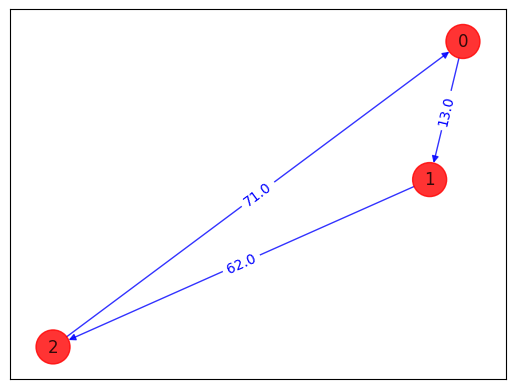

In [15]:
# making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("tsp objective:", result.eigenvalue.real + offset)
x = tsp.sample_most_likely(result.eigenstate) # Compute the most likely binary string from state vector.
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:",z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)


### Running it on quantum computer

In [16]:
algorithm_globals.random_seed = 5678
seed = 56789

/var/folders/kz/_mr3r3b55qd2r5hd025yvpfw0000gn/T/ipykernel_20742/3509499864.py:3: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)


energy: -5311.55356836324
time: 14.188351154327393
feasible: True
solution: [0, 1, 2]
solution objective: 146.0


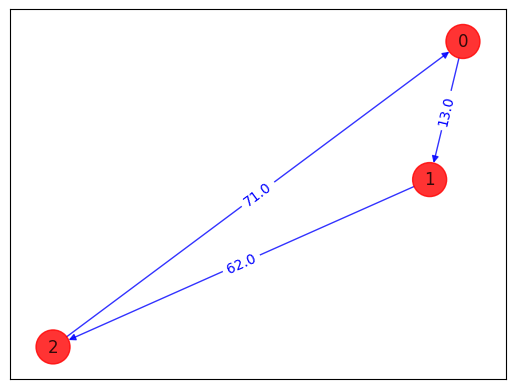

In [17]:
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

result = vqe.compute_minimum_eigenvalue(qubitOp)

print("energy:", result.eigenvalue.real)
print("time:", result.optimizer_time)
x = tsp.sample_most_likely(result.eigenstate)
print("feasible:", qubo.is_feasible(x))
z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

In [21]:
algorithm_globals.random_seed = 3456
seed = 76543

objective function value: 146.0
variable values: x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_1_0=0.0, x_1_1=0.0, x_1_2=1.0, x_2_0=1.0, x_2_1=0.0, x_2_2=0.0
status: SUCCESS
solution: [0, 1, 2]
solution objective: 146.0


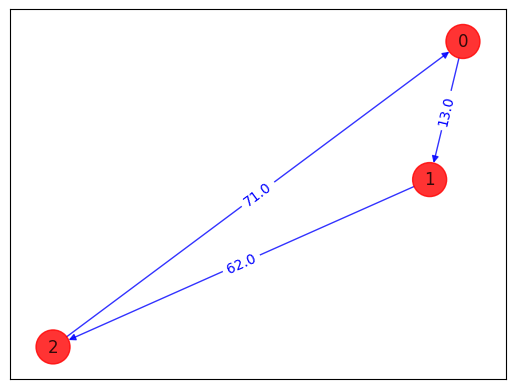

In [22]:
# create minimum eigen optimizer based on SamplingVQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
result = vqe_optimizer.solve(qp)
print(result.prettyprint())

z = tsp.interpret(x)
print("solution:", z)
print("solution objective:", tsp.tsp_value(z, adj_matrix))
draw_tsp_solution(tsp.graph, z, colors, pos)

References:
- [Max-Cut and Traveling Salesman Problem [Qiskit Optimization]](https://qiskit-community.github.io/qiskit-optimization/tutorials/06_examples_max_cut_and_tsp.html#id4)